<a href="https://colab.research.google.com/github/marionwenger/DLColabNotebooks/blob/main/notebooks/03_fcnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST digit classification with and without hidden layers


In this notebook you will use the MNIST dataset for a classification task. You will compare the performance of a fully connected neural network with and without hidden layers.


**Dataset:** You work with the MNIST dataset. We have 60'000 28x28 pixel greyscale images of handwritten digits and want to classify them into the right label (0-9).

**Content:**
* load the original MNIST data
* visualize samples of the data
* flatten the data
* use keras to train a fcNN with and without hidden layers and compare the perfomance on new unseen test data

#### Imports

In the next two cells, we load all the required libraries and functions. We download the Mnist data, normalize the pixelvalues to be between 0 and 1, and seperate it into a training and validation set.

In [1]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers






#### Loading and preparing the MNIST data

In [2]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data() # returns Tuple of NumPy arrays # data ist im keras

y_train[0] # = 5
 # also erster Datenpunkt im Set ist die Handschrift einer 5...

5

In [3]:
# separate x_train in X_train and X_val, same for y_train
X_train=x_train[0:50000] / 255 #divide by 255 so that they are in range 0 to 1
Y_train=to_categorical(y_train[0:50000],10) # one-hot encoding
 # to_categorical: Converts a class vector (integers) to binary class matrix. # num_classes= 10
 # eine 5 wird dann als Vektor geschrieben, siehe unten, es ist nur eine Reformattierung auf einen "one-hot"
 # Y_train[0] # [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]

In [4]:
X_train[0] # numpy matrix  of (28, 28) = one picture # x with all pictures is an array of size 50000
print(X_train[0].shape)
print(X_train.shape)
# (28, 28)
# (50000, 28, 28)

(28, 28)
(50000, 28, 28)


In [5]:

X_val=x_train[50000:60000] / 255 # wir wissen es sind 600000
Y_val=to_categorical(y_train[50000:60000],10)

X_test=x_test / 255
Y_test=to_categorical(y_test,10)

# del x_train, y_train, x_test, y_test  # it causes problems while rerunning cells...

print(Y_val[0].shape)
print(Y_val.shape)

(10,)
(10000, 10)


In [6]:
# RESHAPING --> adding last dimension for Farbkanal
# tupische Form für Tensor
# "mit Squeeze-Funktion könnte man noch die 1 wegbringen, ist hier aber nicht unbedingt nötig"

print(X_train.shape[0]) # = 50000

X_train=np.reshape(X_train, (X_train.shape[0],28,28,1))
X_val=np.reshape(X_val, (X_val.shape[0],28,28,1))
X_test=np.reshape(X_test, (X_test.shape[0],28,28,1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

50000
(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(50000, 10)
(10000, 10)
(10000, 10)


In [7]:
# verstehe diese 1 am Schluss noch nicht... warum hat man die hinzugefügt?
# print(X_train[0])
# 28 mal 28 Vector mit Werten zwischen 0 und 1 --> 28x28 pixel vom Bild
# aber was ist mit der letzten Dimension??? ich sehe sie nicht...

Let's visualize the first 4 mnist images. It is very easy to recognise the true label of the digits.

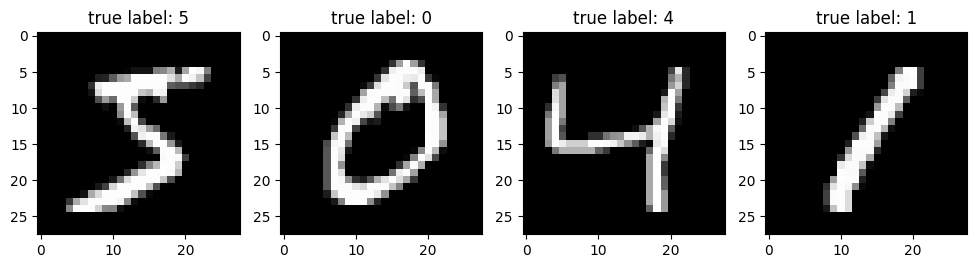

In [8]:
# visualize the 4 first mnist images
plt.figure(figsize=(12,12))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+str(np.argmax(Y_train,axis=1)[i])) # man schaut im one-hot wo die 1 ist um die Zahl zu identifizieren
    #plt.axis('off')

## fcNN as classification model for MNIST data
Now we want to train a fcNN to classify the MNIST data.
We use two network architectures:
* fcnn with no hidden layers
* fcnn with two hidden layers (100 and 50)


Because we will use fcNN we need to flatten our inuput into a 1d vector. We do this in the next cell with reshape.

In [9]:
# prepare data for fcNN - we need a vector as input

# anstatt 28x28 matrix, ein 784 vector
# --> algo does not capitalize on nighbourhood of pixels like we humans!!! see later...

# first do it for original data
# mysteriöse Dimension verschwindet hier!!!
X_train_flat = X_train.reshape([X_train.shape[0], 784])
X_val_flat = X_val.reshape([X_val.shape[0], 784])
X_test_flat = X_test.reshape([X_test.shape[0], 784])

### Train the first fcNN on the data

In [10]:
# check the shape
X_train_flat.shape,Y_train.shape,X_val_flat.shape,Y_val.shape

((50000, 784), (50000, 10), (10000, 784), (10000, 10))

Here we define the nework. In the output we predict the probability for the 10 digits with the softmax activation function.

In [11]:
# define fcNN
model = Sequential()

model.add(Dense(10, batch_input_shape=(None, 784), activation="softmax"))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
# summarize model along with number of model weights
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# train the model
history=model.fit(X_train_flat, Y_train,
                  batch_size=128,
                  epochs=10,
                  verbose=0, #2,
                  validation_data=(X_val_flat, Y_val)
                 )

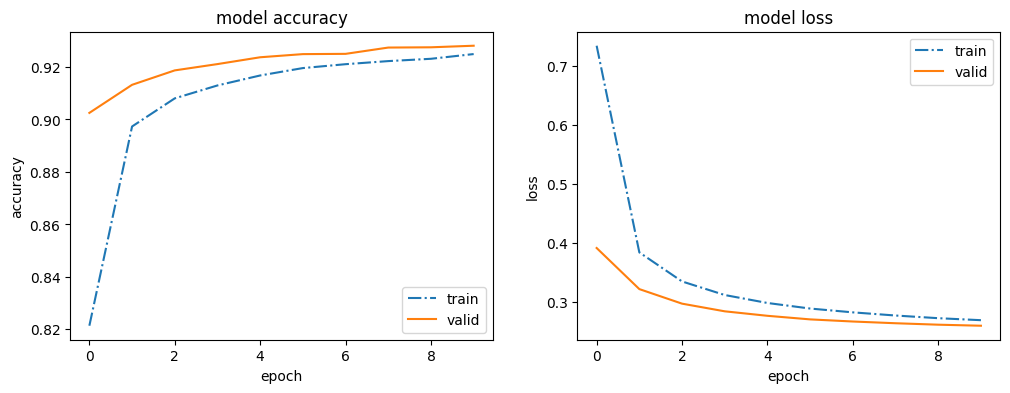

In [14]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# berechnen auf test data, predict auf validation data
# Zeitpunkt loss Berechnung jeweils Anfang und Ende der Epoche, also nicht gleichzeitg
# vermutlich deshalb kleine Difference zwischen valid und train, train hinkt vermutlich wie eine Epoche hinterher...
# [speculation by teacher]
# article online (Medium):
# https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e

#### Prediction on the test set

Now, let's use the fcNN that was trained to predict new unseen data (our testdata).
We determine the confusion matrix and the accuracy on the testdata to evaluate the classification performance.


Accuracy =  0.9257


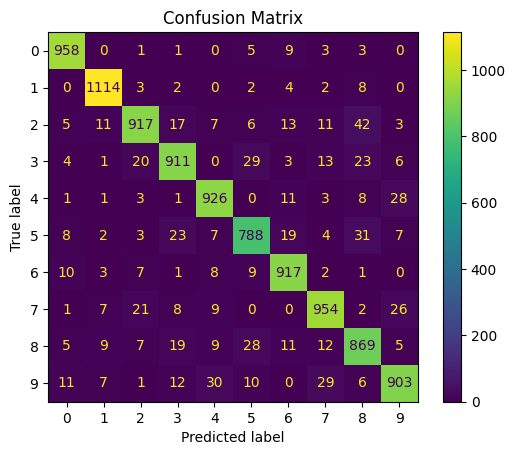

In [15]:
# predict each instance of the testset
pred=model.predict(X_test_flat, verbose = 0)
# get confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(pred, axis=1))

acc_fc = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Accuracy = " , acc_fc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

### Train the second fcNN on the data

Now, we define the nework with two hidden layers (100, 50). We use the sigmoid activation function on the hidden layers. In the output we predict the probability for the 10 digits with the softmax activation function.

In [16]:
# define fcNN with 2 hidden layers
model = Sequential()

model.add(Dense(100, batch_input_shape=(None, 784)))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
# summarize model along with number of model weights
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                510       
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 84060 (328.36 KB)
Trainable params: 8406

In [18]:
# train the model
history=model.fit(X_train_flat, Y_train,
                  batch_size=128,
                  epochs=10,
                  verbose=0, #2,
                  validation_data=(X_val_flat, Y_val)
                 )

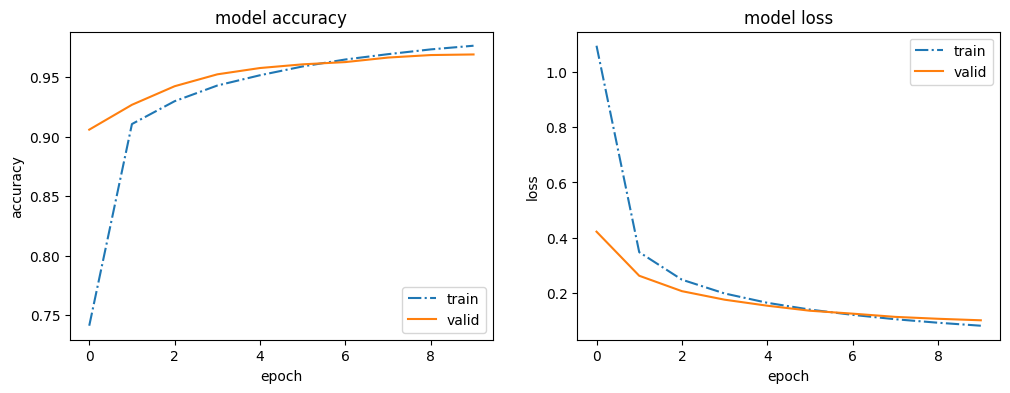

In [19]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

Accuracy =  0.9705


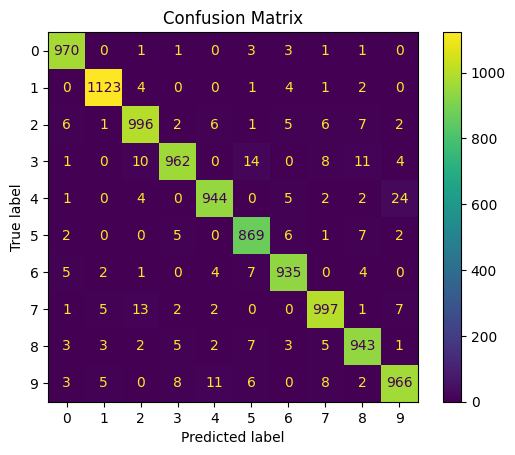

In [20]:
# predict each instance of the testset
pred=model.predict(X_test_flat, verbose = 0)
# get confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(pred, axis=1))

acc_fc = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Accuracy = " , acc_fc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

## Exercise  

What do you observe when you compare the network with the hidden layers to the one without?  
  
Try to improve the fcNN by adding more hidden layers and/or changing the activation function from "sigmoid" to "relu". What do you observe?


In [21]:
# define fcNN with 3 hidden layers
model = Sequential()

model.add(Dense(50, batch_input_shape=(None, 784)))
model.add(Activation('sigmoid'))
model.add(Dense(100))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                39250     
                                                                 
 activation_3 (Activation)   (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 100)               5100      
                                                                 
 activation_4 (Activation)   (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 activation_5 (Activation)   (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 10)               

In [23]:
# train the model
history=model.fit(X_train_flat, Y_train,
                  batch_size=128,
                  epochs=10,
                  verbose=0, #2,
                  validation_data=(X_val_flat, Y_val)
                 )

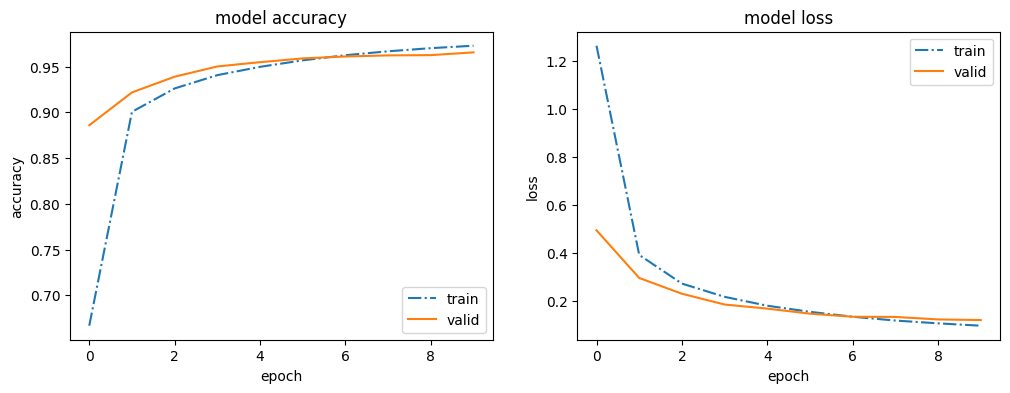

In [24]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# es wird nicht besser, sondern schlechter...
# und es wird früher schlechter als vorher, in Epoch 5 anstatt 6

In [25]:
# define fcNN with 2 hidden layers
model = Sequential()

model.add(Dense(100, batch_input_shape=(None, 784)))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 activation_7 (Activation)   (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 activation_8 (Activation)   (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                510       
                                                                 
 activation_9 (Activation)   (None, 10)                0         
                                                                 
Total params: 84060 (328.36 KB)
Trainable params: 8406

In [27]:
# train the model
history=model.fit(X_train_flat, Y_train,
                  batch_size=128,
                  epochs=10,
                  verbose=0, #2,
                  validation_data=(X_val_flat, Y_val)
                 )

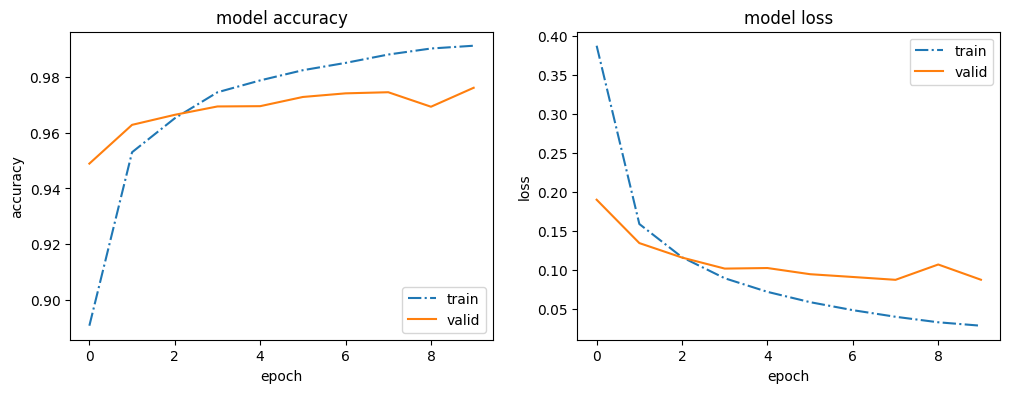

In [28]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# es wird nur auf den Trainingsdaten besser, nicht auf dem validation set...
# die accuracy wird bei early stopping noch leicht besser als im vorherigen Modell, aber der Loss nicht kleiner...

Accuracy =  0.9769


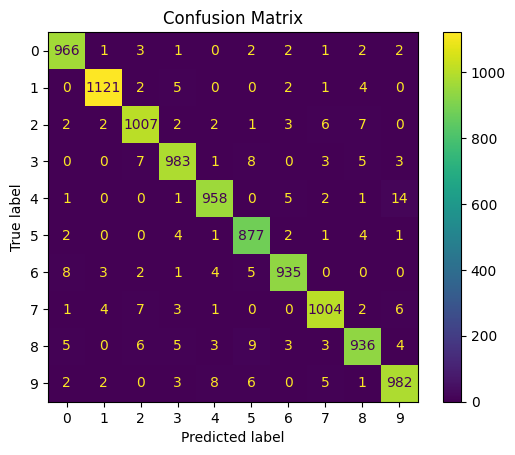

In [29]:
# predict each instance of the testset
pred=model.predict(X_test_flat, verbose = 0)
# get confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(pred, axis=1))

acc_fc = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Accuracy = " , acc_fc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# etwa gleich wie vorher...